In [1]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
from scipy.integrate import *
import numpy as np
import matplotlib.pyplot as plt
from cmath import *
from scipy.signal import *
from scipy import signal

In [2]:
# setting ring parameters
# from PDK RMCTE_R5AP_LPN_WG_450

# coupled through coefficient
gamma = 0.95012

# modulation efficiency ( m/V, -0.5~0.5V )
# me = -38.7e-12
# # modulation efficiency ( m/V, -1~0.5V )
me = -37.2e-12

neff = 2.51464

# round trip tranmission coefficient (no unit)
alpha = 0.95246

# radius of ring
radius = 5e-6

# group velocity
ng = 4.3

# length of active region
La = 2*np.pi*radius

In [3]:
# driving parameters
square_wave = True
sine_wave = False
raise_cosine =False

# dc bias
v_bias = -1
# vpp
vpp = 1

# driving frequency (GHz)
f = 50
w_drive = 2*np.pi*f*1e9

# series resistance
R = 53.9

# junction capacitance at difference bias
# according to PDK data
# if v_bias >=0:
#     Cj = 23.6e-15 
# if v_bias ==-1:
#     Cj = 20e-15 
# if v_bias ==-2:
#     Cj = 18.5e-15 
def Cj(V):
    return 3.7675e-14/( (2.5485-V)**0.5 )

# def rcos(t,beta,T):
#     if not (beta==0):
#         if (t*t0==T/2/beta or t*t0==-T/2/beta):
#             return np.pi/4/T*sinc(1/2/beta)
#     return 1/T*np.sinc(t*t0/T)*np.cos(np.pi*beta*t*t0/T)/(1-(2*beta*t*t0/T)**2)




In [4]:
# calculating ring resonant frequency

# Since coupled mode theory in time only consider one resonant frequency. 
# When deriving w0, one must find the integar of 2pi which the resonant is near 1550nm .
# Note that the integar is even for resonant frequency, odd for anti-resonant frequency
c = 299792458
L=2*np.pi*radius
w0 = 102*np.pi*c/(neff*L)
lambda0 = 2*np.pi*c/w0

In [5]:
# setting incident light 
# incidnet light frequency or wavelength
change_lambda = True
change_w = False
if change_lambda:
    wl =1.5488e-6
    w = 2*np.pi*c/wl
if change_w:
    w = 102/102*w0
    wl =2*np.pi*c/w

In [6]:
# calculating parameter in couple mode equation in time

kappa = (1-gamma**2)**0.5

# photon life time in ring 
tu_o = -L*ng/(c*log(alpha))
tu_e = -L*ng/(c*log(sqrt(1-kappa**2)))



In [7]:
# setting solver parameters

# time interval 
t_min=0
t_max = 200
w_drive = 2*np.pi*f*1e9
b_init = 0+1j*0
Q_init = 0

# relative solver tolerance 
rtol = 1e-15
# absolute solver tolerance
atol = 1e-20
# accuracy = atol + abs(y)*rtol

# method of solving algorithm
method = 'RK45'

# most high time accuracy in the result
dt = 1e-16

# shifting frequency of field in ring from incident light frequency
w_pround = w

In [8]:
# normalize factors
t0 = 1e-12; 

S0 = 1
b0 = sqrt(t0)*S0
tu_t = (1/tu_e+1/tu_o)**(-1)
tu_t_bar = tu_t/t0
tu_e_bar = tu_e/t0

# normalized dw/dlambda
D_bar = -2*np.pi*c/lambda0**2 * t0

# normalized frequency
w0_bar = w0*t0
w_pround_bar = w_pround*t0


In [9]:
# defining functions

# incident light
def S_plus(w,t):
    return 1*np.exp(1j*w*t*t0)

# incident light (shifted to w_pround)
def S_plus_pround(t):
    return S_plus(w,t)*np.exp(-1j*w_pround*t*t0)

# driving voltage
def sinc(t):
    if t==0:
        return 1
    else:
        return np.sin(np.pi*t)/(np.pi*t)

def rcos(t,beta,T,t0=t0):
    # print(type(t))
    # L = len(t)
    # a = np.zeros(L)
    if not (beta==0):
        if (t*t0==T/2/beta or t*t0==( -T/2/beta)):
            # a[i] = np.pi/4*sinc(1/2/beta)
            return np.pi/4*sinc(1/2/beta)
        else:
            # a[i]=sinc(t[i]*t0/T)*np.cos(np.pi*beta*t[i]*t0/T)/(1-(2*beta*t[i]*t0/T)**2)
            return sinc(t*t0/T)*np.cos(np.pi*beta*t*t0/T)/(1-(2*beta*t*t0/T)**2)
        
    # return a

def v(w_drive,t):
    if square_wave:
        return vpp/2*signal.square(w_drive*t*t0,duty=0.5)+v_bias
    if sine_wave:
        return vpp/2*np.exp(1j*w_drive*t*t0)+v_bias
    if raise_cosine:
        T_period = 1/(f*1e9)/2
        T_period_normalized = T_period/t0
        beta = 1
        # a = np.zeros(len(t_total))
        a=0
        N = int(t_max*t0//(2*2*T_period))
        # a = vpp/2*rcos(t-5*T_period/t0,beta, T_period)+v_bias
        for i in range(N+1):
            a += ( vpp/2*rcos(t-(i*2*2+1)*T_period_normalized, beta, T_period)+v_bias ) 
        return a

    

# incident light (shifted to w_pround)
def S_plus_pround_bar(t):
    return S_plus_pround(t)/S0


In [10]:
# defining CMT function
t_total = np.arange(t_min,t_max,dt/t0)
t_pround = t_total*t0

# normalized coupling coefficient in time
kappa_time = sqrt(2/tu_e_bar)


def CMT(t_bar,eqs):
    b_bar , Q_pround = eqs
    f2 = (v(w_drive,t_bar)/(R*Cj(v(w_drive,t_bar)))*t0) - (1/( R*Cj( v(w_drive,t_bar) ) ) )*Q_pround*t0
    f1 = 1j*(w0_bar-w_pround_bar)*b_bar- (1/tu_t_bar)*b_bar + kappa_time *S_plus_pround_bar(t_bar)+1j*D_bar*me*Q_pround*b_bar
    
    return [ f1,f2 ]


In [11]:
# solving CMT
sol = solve_ivp(CMT ,[t_min ,t_max], [b_init, Q_init],method=method,t_eval = t_total,atol = atol,rtol = rtol)


c:\Users\kevin\anaconda3\lib\site-packages\scipy\integrate\_ivp\common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


In [12]:
b_bar = (sol.y[0])
t_vals = np.arange(t_min*t0,t_max*t0,dt)
b_bar_vals = np.interp(t_vals, t_total*t0, b_bar)
a_bar_vals = b_bar_vals*np.exp(1j*w_pround*t_vals)

s_minus_bar = (S_plus(w_pround,t_vals/t0)/S0-sqrt(2/tu_e_bar)*a_bar_vals)

c:\Users\kevin\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


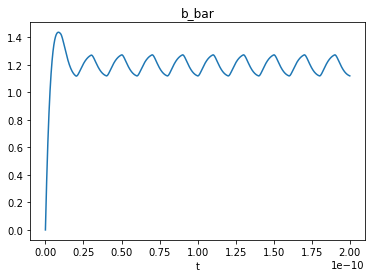

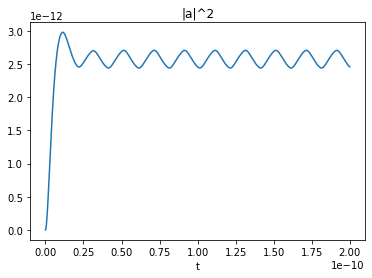

c:\Users\kevin\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


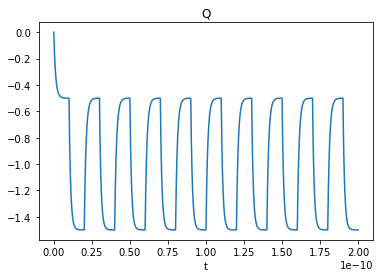

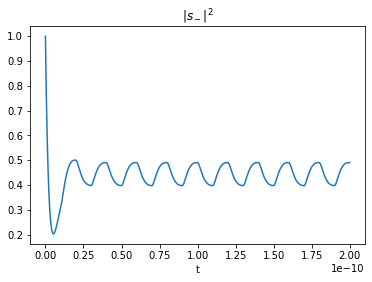

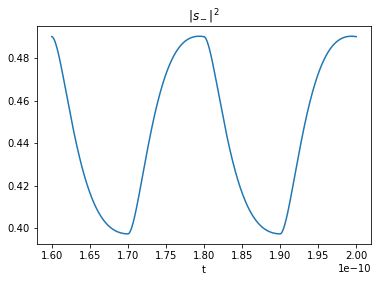

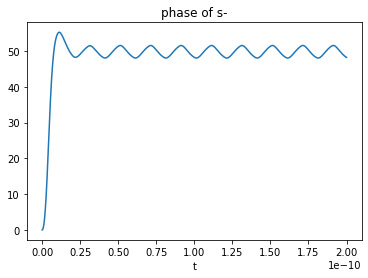

In [13]:
plt.figure()
plt.plot(t_total*t0,b_bar )
plt.title("b_bar")
plt.xlabel('t')
plt.show()

# plt.figure()
# plt.plot(t_total*t0, v(w_drive,t_total))
# plt.title("applied voltage")
# plt.xlabel('t')
# plt.show()

plt.figure()
plt.plot(t_total*t0, abs(a_bar_vals*b0)**2)
plt.title(r"|a|^2")
plt.xlabel('t')
plt.show()

plt.figure()
plt.plot(t_total*t0, (sol.y[1]))
plt.title("Q")
plt.xlabel('t')
plt.show()

# plt.figure()
# plt.plot(t_total[-int(len(s_minus_bar)/10*2):-1]*t0, (sol.y[1][-int(len(s_minus_bar)/10*2):-1])*Cj(v(w_drive,t_total[-int(len(s_minus_bar)/10*2):-1])))
# plt.title("Q")
# plt.xlabel('t')
# plt.show()

plt.figure()
plt.plot(t_total*t0, abs(s_minus_bar*S0)**2)
plt.title(r'$|s_-|^2$')
plt.xlabel('t')
plt.show()

plt.figure()
plt.plot(t_total[-int(len(s_minus_bar)/10*2):-1]*t0, abs(s_minus_bar[-int(len(s_minus_bar)/10*2):-1]*S0)**2)
plt.title(r'$|s_-|^2$')
plt.xlabel('t')
plt.show()

plt.figure()
plt.plot(t_total*t0, 180/np.pi*np.angle(s_minus_bar*b0*np.exp(-1j*w*t_total*t0)))
plt.title(r'phase of s-')
plt.xlabel('t')
plt.show()

In [14]:
print(abs(a_bar_vals*b0)**2)

[0.00000000e+00 2.27097621e-21 9.08370351e-21 ... 2.45559729e-12
 2.45559520e-12 2.45559310e-12]


In [15]:
phase_s_max = max(180/np.pi*np.angle(s_minus_bar[-int(len(s_minus_bar)/10*2):-1]*S0*np.exp(-1j*w*t_total[-int(len(s_minus_bar)/10*2):-1]*t0)))
phase_s_min = min(180/np.pi*np.angle(s_minus_bar[-int(len(s_minus_bar)/10*2):-1]*S0*np.exp(-1j*w*t_total[-int(len(s_minus_bar)/10*2):-1]*t0)))
print('max of s_minus = ',phase_s_max)
print('min of s_minus = ',phase_s_min)

max of s_minus =  51.57649544022351
min of s_minus =  48.0669797916367


In [16]:
s_max = max(abs(s_minus_bar[-int(len(s_minus_bar)/10*2):-1]*S0)**2)
s_min = min(abs(s_minus_bar[-int(len(s_minus_bar)/10*2):-1]*S0)**2)
print('max of s_minus = ',s_max)
print('min of s_minus = ',s_min)

max of s_minus =  0.4903170406986071
min of s_minus =  0.3971992147436847


In [17]:
ER = 10*log10(s_max/s_min)
print("Extinction ratio = ", ER)

Extinction ratio =  (0.9146860594276852+0j)


In [18]:
# Q factor of ring
Q_factor = (2/w0/tu_e + 2/w0/tu_o)**-1
print("Q factor of ring is ",np.real(Q_factor))

Q factor of ring is  2743.2132540748134
